## Inhaltsverzeichnis
- [Import der Libraries](#Datenextraktion)
- [1. Datenextraktion](#Datenextraktion)
  - [1.1 Hilfsmethoden](#Hilfsmethoden)
  - [1.2 Methode zum Erstellen des Data Frames](#create_data_frame)
- [2. Histogramm (Top10 Autoren - Anzahl der Artikel)](#Histogramm)
  - [2.1 Datenaufbereitung](#Histo_Dataprep)
  - [2.2 Histogramm über den gesamten Zeitraum aufgeteilt pro Artikel/Jahr der Top 10 Autoren](#Histo_diagram)
- [3. Data Mining auf strukturierten Daten](#Data_Mining)
  - [3.1 Anzahl der Artikel pro Jahr zu dem Thema "Data driven"](#CountArtiklesYear)
  - [3.2 Anzahl der Artikel pro Monat über die Jahre](#CountArtiklesMonth)
  - [3.3 Anzahl Autoren pro Jahr zum Thema "Data driven"](#CountAuthorsYear)
  - [3.4 Durchnitt der Autoren pro Artikel über die Jahre verteilt](#AvgAuthorsPerArticle)
  - [3.5 Korrelation Artikel und Autoren](#Korrelation)
  - [3.6 Artikel in den Hauptkategorien](#ArticlesInPrimaryCats)
  - [3.7 Verteilung der Artikel auf alle Kategorien](#DistributionArticleCats)
  - [3.8 Verteilung der Rubriken (Übergeordnete Kategorienamen) nach Jahren](#DistributionCatsYears)
- [4. Data Mining auf unstrukturierten Daten](#DataMining_UnstructuredData)
  - [4.1 Verstehen der Daten (Understanding)](#Understanding)
  - [4.2 Datenvorbereitung (Data Preparation)](#Preparation)
    - [4.2.1 Stopwörter und Satzzeichen entfernen](#StopWords)
    - [4.2.2. Stemmung bzw. Lemmatisierung](#Lemmatization)
    - [4.2.3 Numerische Werte entfernen](#RemoveNumericValues)
    - [4.2.4 Text in Zahlenvektoren umwandeln](#TextToNumbers)
  - [4.3 Modellieren (Modeling)](#Modeling)
    - [4.3.1 LDA](#LDA)
    - [4.3.2 Wordcloud](#Wordcloud)
  - [4.4. Auswertung (Evaluation)](#Evaluation)

# Assignment im Modul ROB60 - Maschinelles Lernen

## Import der Libraries <a name="Datenextraktion"></a>

In [1]:
import requests
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET

import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from langdetect import detect
from nltk.stem import WordNetLemmatizer
import re
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords') 

from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

from wordcloud import WordCloud
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alwin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Alwin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alwin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Datenextraktion <a name="Datenextraktion"></a>
Besuchen Sie die Website https://arxiv.org/ , die die wichtigste Ressource für Arbeitspapiere aus der Informatik ist. Sie wählen ein Stichwort wie "Deep Reinforcement Learning" oder "Topic Modeling" (Sie können das Stichwort frei wählen) und extrahieren genügend Metadaten zu Artikeln im XML-Format (mehr als 100-200 Artikel pro Jahr) von der Website unter Verwendung der bereitgestellten API https://arxiv.org/help/api & https://arxiv.org/help/api/basics 

### 1.1 Hilfsmethoden  <a name="Hilfsmethoden"></a>

Hilfsmethoden zum Einlesen der einzelnen Metadaten

In [2]:
# Namespace im Rückgabedokument, wichtig für die Suche von Knoten und Attributen im Response
ns = {"atom": "http://www.w3.org/2005/Atom",
      "arxiv": "http://arxiv.org/schemas/atom"}
    
# Funktion zur Ermittlung der Kommentare
def get_comment(entry):
    comment_node = entry.find("arxiv:comment", ns)
    if comment_node is not None:
        return comment_node.text
    else:
        return None
        
# Funktion zur Ermittlung der Kategorien (abgesehen der primary)
def get_categories(entry):
    categories = list()
    for category in entry.findall("atom:category", ns):
        categories.append(category.get("term"))
        
    return ", ".join(categories)

### 1.2 Methode zum Erstellen des Data Frames <a name="create_data_frame"></a>

Nach einer Prüfung der Metadaten und ihrer Relevanz wurde sich dazu entschieden die folgenden Metadaten auszulesen:
- title
- summary
- authors
- published
- p_category
- categories

Und die folgenden nicht, da diese irrelevant scheinen oder nicht ausreichend befüllt wurden um eine sinnvolle Analyse zu ermöglichen:
- affilitations (wurden kaum befüllt lediglich 72 Werte für über 3500 Artikel)
- comment (
- journal (wurde kaum befüllt lediglich 1/7 der Daten hatte Werte und zumeist auch eindeutige und keine kategorischen)

In [3]:
def create_data_frame():
    # API URL von arxiv
    url = "http://export.arxiv.org/api/query"

    # Query für die Artikelselektion. 
    # Ich habe eine von der Webseite vorgeschlagene Kategorie ausgesucht, die viele Artikel verspricht. 
    # Sucbegriff: Data Structures and Algorithms
    search_query = "search_query=ti:Data+AND+Driven"

    # Reihenfolge der Spalten für das DataFrame
    columns = ("title", "summary", "authors", "published", "p_category", "categories", "comment")

    data = []
    # Jahre, die es auszulesen gilt
    relevant_years = ["2017", "2018", "2019", "2020", "2021", "2022"]
    year = "2023"
    # Jahr bei dem gestoppt werden soll.
    stop_year = "2016"
    start = 0
    max_results_per_call = 100
    
    # Solange das Stopjahr noch nicht erreicht wurde...
    while year != stop_year:
        # ... lege die Parameter für den API-Call fest...
        results = f"max_results={max_results_per_call}"
        start_index = f"start={start}"

        # ... initialsiere den API-Call mit den neuen Parametern...
        query_url = f"{url}?{search_query}&{results}&{start_index}&sortBy=submittedDate&sortOrder=descending"
        res = requests.get(query_url)
        root_node = ET.fromstring(res.content)

        # ... lese die Metadaten für jeden Eintrag aus,
        for entry in root_node.findall("atom:entry", ns):
            published = entry.find("atom:published", ns).text

            # Abbruchkriterium, da absteigende Sortierung für gewählt wurde, werden nur aktuellste Artikel bis
            # einschließlich 2017 ausgelesen. Eine andere Möglichkeit zum Lesen der Daten konnte nicht eruiert werden,
            # da die API keine Filterung für einen Zeitraum anbietet.
            year = published[0:4]
            if year == stop_year:
                break
                
            # Zum Ausfiltern der Artikel aus 2023 wird hier abgefragt ob das Jahr relevant ist, wenn ja...
            if year in relevant_years:
                # ... werden die Metadatan ausgelesen:
                title = entry.find("atom:title", ns).text
                summary = entry.find("atom:summary", ns).text

                # Die Namen der Autoren stehen im author-tag als Einzeleinträge, also alle Namen auslesen in eine Liste
                authors = [author.find("atom:name", ns).text for author in entry.findall("atom:author", ns)]

                # Primary Category wird als extra "Feature" eingelesen
                primary_category = entry.find("arxiv:primary_category", ns).get("term")
                
                categories = get_categories(entry)
                comment = get_comment(entry)

                # Die Reihenfolge ist wichtig und sollte sich an der Reihenfolge der columns richten.
                data.append((title, summary, ", ".join(authors), published, 
                             primary_category, categories, comment))

        # Startindex hochzählen um die maximale Anzahl per Call
        start += max_results_per_call

    df = pd.DataFrame(data, columns=columns)
    return df

In [4]:
df = create_data_frame()

# Spaltennamen für den Index geändert auf Artikel-Nummer
df = df.rename_axis("article_no")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3394 entries, 0 to 3393
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       3394 non-null   object
 1   summary     3394 non-null   object
 2   authors     3394 non-null   object
 3   published   3394 non-null   object
 4   p_category  3394 non-null   object
 5   categories  3394 non-null   object
 6   comment     1828 non-null   object
dtypes: object(7)
memory usage: 185.7+ KB


## 2. Histogramm (Top10 Autoren - Anzahl der Artikel) <a name="Histogramm"></a>
Erstellen Sie ein Histogramm über die Anzahl der Artikel pro Autor (Visualisieren Sie nur die 10 Autoren mit der höchsten Anzahl von Artikeln). Organisieren Sie die Daten in den verschiedenen Zeitintervallen für das Jahr (veröffentlicht am) 2017, 2018 und 2019, 2020, 2021, 2022 (habe ich ergänzt, da bereits 2023 ist :-) ).

### 2.1 Datenaufbereitung <a name="Histo_Dataprep"></a>

In [5]:
# published umwandeln in Datum
df['published'] = pd.to_datetime(df['published'], format='%Y-%m-%d')
# Neue Spalte für Veröffentlichungsjahr generieren
df["year"] = pd.to_datetime(df['published']).dt.year

In [6]:
# Autoren auf Zeilen aufteilen, da ein Artikel mehr als einen Autor haben kann
df_authors = df['authors'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True).to_frame()
df_authors.columns = ["author"]

# Artikel-Nummer entsprechend benennen
df_authors = df_authors.rename_axis("article_no")
df_authors.head()

author
article_no                   
0             Jenna M. Reinen
0                Carla Agurto
0            Guillermo Cecchi
0           Jeffrey L. Rogers
0                     NAVITAS

In [7]:
# Entstandene Dataframes mergen um wieder alle Informationen zu erhalten
df_merged_authors = pd.merge(df, df_authors, on='article_no')
df_merged_authors.head()

title  \
article_no                                                      
0           Definition and clinical validation of Pain Pat...   
0           Definition and clinical validation of Pain Pat...   
0           Definition and clinical validation of Pain Pat...   
0           Definition and clinical validation of Pain Pat...   
0           Definition and clinical validation of Pain Pat...   

                                                      summary  \
article_no                                                      
0             The technical capacity to monitor patients w...   
0             The technical capacity to monitor patients w...   
0             The technical capacity to monitor patients w...   
0             The technical capacity to monitor patients w...   
0             The technical capacity to monitor patients w...   

                                                      authors  \
article_no                                                      
0           Jenna M. Reinen, Carla Agurto, Guillermo Cecch...   
0           Jenna M. Reinen, Carla Agurto, Guillermo Cecch...   
0           Jenna M. Reinen, Carla Agurto, Guillermo Cecch...   
0           Jenna M. Reinen, Carla Agurto, Guillermo Cecch...   
0           Jenna M. Reinen, Carla Agurto, Guillermo Cecch...   

                           published p_category         categories comment  \
article_no                                                                   
0          2022-12-31 22:11:37+00:00    stat.AP  stat.AP, q-bio.QM    None   
0          2022-12-31 22:11:37+00:00    stat.AP  stat.AP, q-bio.QM    None   
0          2022-12-31 22:11:37+00:00    stat.AP  stat.AP, q-bio.QM    None   
0          2022-12-31 22:11:37+00:00    stat.AP  stat.AP, q-bio.QM    None   
0          2022-12-31 22:11:37+00:00    stat.AP  stat.AP, q-bio.QM    None   

            year             author  
article_no                           
0           2022    Jenna M. Reinen  
0           2022       Carla Agurto  
0           2022   Guillermo Cecchi  
0           2022  Jeffrey L. Rogers  
0           2022            NAVITAS

In [8]:
# Dataframe mit den Artikeln der Autoren im entsprechenden Jahr
articles_by_authors = df_merged_authors.groupby(['year', 'author']).size().reset_index(name='count_articles')
articles_by_authors.head()

year          author  count_articles
0  2017         Prabhat               1
1  2017          A. Koc               1
2  2017  A. M. Mendonça               1
3  2017    A. Marinelli               1
4  2017    A. S. Vemuri               1

In [9]:
# Ermittle die Anzahl der Artikel pro Autor pro Jahr
articles_by_authors = df_merged_authors.groupby(['year', 'author']).size().reset_index(name='count_articles')
df_grouped = articles_by_authors.groupby(['year', 'author'])['count_articles'].sum().reset_index()
df_grouped.sort_values('count_articles', ascending=False).head()

year             author  count_articles
8288   2021     Frank Allgöwer              10
5237   2020     Frank Allgöwer               9
12993  2022     Frank Allgöwer               9
10466  2021        Pietro Tesi               8
7702   2021  Claudio De Persis               8

In [10]:
# Bestimme die Top 10 Autoren aus dem Gesamtzeitraum (2017-2022)
df_top_authors = df_grouped.groupby('author')['count_articles'].sum().reset_index()\
                .sort_values('count_articles', ascending=False)[:10]
df_top_authors

author  count_articles
3977       Frank Allgöwer              33
6409     Julian Berberich              25
5454       J. Nathan Kutz              20
11861   Steven L. Brunton              18
2400    Claudio De Persis              16
9922          Pietro Tesi              16
8595        Michael Ortiz              15
4314      Gianluigi Rozza              14
8330   Matthias A. Müller              14
6193         John Lygeros              13

In [11]:
# Filterung des Datenbestands, damit nur noch die Daten der Top 10 Autoren ausgegeben werden
top_authors_data = df_grouped[df_grouped['author'].isin(df_top_authors['author'])].sort_values("count_articles", ascending=False)
top_authors_data.head()

year             author  count_articles
8288   2021     Frank Allgöwer              10
12993  2022     Frank Allgöwer               9
5237   2020     Frank Allgöwer               9
13603  2022   Julian Berberich               8
7702   2021  Claudio De Persis               8

### 2.2 Histogramm über den gesamten Zeitraum aufgeteilt pro Artikel/Jahr der Top 10 Autoren  <a name="Histo_diagram"></a>

In [12]:
fig = go.Figure()

year_colors = px.colors.sequential.Viridis[:len(top_authors_data["year"].unique())]

top_authors_data = top_authors_data.sort_values("year")

for i, year in enumerate(top_authors_data['year'].unique()):
    y_values = top_authors_data.loc[top_authors_data['year'] == year, 'count_articles']
    x_values = top_authors_data.loc[top_authors_data['year'] == year, 'author']
    fig.add_trace(go.Bar(x=x_values, y=y_values, name=str(year), marker_color=year_colors[i]))
    
fig.update_layout(barmode='relative', title_text='Artikel pro Autor, aufgeteilt in Jahre')
fig.show()

> Aus dieser Grafik lässt sich entnehmen, dass einige Autoren konstant in dem Jahren Beiträge veröffentlicht haben und einige erst im Jahr 2019 damit begonnen haben sich mit dem Thema auseinander zu setzen. Die neuen Autoren veröffentlichen auch anzahlmäßig mehr Artikel als die "alteingesessenen".

## 3. Data Mining auf strukturierten Daten  <a name="Data_Mining"></a>
Führen Sie eine deskriptive Analyse der strukturierten Daten für die verschiedenen Jahre aus, um herauszufinden, ob sich „etwas“ über die Jahre signifikant verändert hat, wie zum Beispiel Anzahl der Artikel pro Monat, Anzahl der Autoren, Keywords, etc. 

### 3.1 Anzahl der Artikel pro Jahr zu dem Thema "Data driven" <a name="CountArtiklesYear"></a>

Für eine umfassende Analyse des Themas "Data Driven" ist es wichtig, die Anzahl der Artikel pro Jahr zu untersuchen. Eine solche Analyse gibt uns einen Überblick darüber, wie sich das Interesse an diesem Thema im Laufe der Zeit entwickelt hat und ob es in bestimmten Jahren ein besonderes Interesse gab.

In [13]:
# Daten gruppieren nach Jahr um die Summe der Artikel pro Jahr zu ermitteln
articles_per_year = df.groupby('year').size().reset_index(name='count')

# Farbschemata für die Jahre 2017 bis 2022
year_colors = px.colors.sequential.Viridis[:len(df['year'].unique())] 

fig = go.Figure()

# Anzahl der Autoren als Linie
fig.add_trace(go.Scatter(x=articles_per_year['year'], y=articles_per_year['count'], name='Anzahl der Artikel',
                         line=dict(color=year_colors[1])))

# Trendlinie (gestichelt) für die Anzahl der Autoren
z = np.polyfit(articles_per_year['year'], articles_per_year['count'], 1)
p = np.poly1d(z)
trendline = go.Scatter(x=articles_per_year['year'], y=p(articles_per_year['year']),
                       mode='lines', name='Trendlinie', line=dict(dash='dash', color=year_colors[3]))
fig.add_trace(trendline)

# Titel und Achsenbeschriftungen
fig.update_layout(title='Verlauf der Artikelanzahl pro Jahr zum Thema "Data driven"',
                  xaxis_title='Jahr',
                  yaxis_title='Anzahl der Artikel',
                  colorway=year_colors)

fig.show()

> Das Thema "Data driven" gewinnt immer weiter an Bedeutung seit 2019. Es werden knapp das vierfache an Artikeln veröffentlicht, die im Titel die Stichpunkte "Data" und "driven" aufweisen. Die Trendlinie verdeutlicht dies nochmal

### 3.2 Anzahl der Artikel pro Monat über die Jahre <a name="CountArtiklesMonth"></a>
Die Analyse der Anzahl der Artikel pro Monat über die Jahre hilft die Trends und Veränderungen im Themenbereich "Data driven" zu identifizieren. Durch die Aufteilung der Daten nach Monaten können saisonale Muster erkannt werden, die Aufschluss darüber geben können, ob bestimmte Monate oder Jahreszeiten bevorzugt werden, um Artikel zu diesem Thema zu veröffentlichen.

In [14]:
# Artikel nach Jahr und Monat gruppieren um die Anzahl der Artikel pro Monat im Jahr zu ermitteln.
articles_per_month = df.groupby([df['published'].dt.year.rename('year'), df['published'].dt.month.rename('month')]).size().reset_index(name='count')

fig = go.Figure()

for i, year in enumerate(top_authors_data['year'].unique()):
    y_values = articles_per_month.loc[articles_per_month['year'] == year, 'count']
    x_values = articles_per_month.loc[articles_per_month['year'] == year, 'month']
    fig.add_trace(go.Bar(x=x_values, y=y_values, name=str(year), marker_color=year_colors[i]))
    
fig.update_layout(barmode='relative', title_text='Artikel pro Monat unterteilt in Jahreswerte')
# Achsen- und Legendenbezeichnung ändern
fig.update_layout(xaxis=dict(title='Monat', tickmode='linear', tick0=1, dtick=1),
                  yaxis=dict(title='Anzahl Artikel'))
fig.update_layout(legend_title_text='Jahr')

fig.show()

> Hier sieht man, dass die Veröffentlichungen in den einzelnen Monaten natürlichen Schwankungen unterliegen. Deutlich ist ein Ansteig von Publikationen in den Herbst und Wintermonaten. 

> Im März war besonders das Jahr 2021 zahlreich mit Artikeln gesegnet, insgesamt 121 Artikel wurden hier veröffentlicht. Das einzige mal, dass die Hundert überstiegen wurde. Dies kann an der Pandemie liegen, hier konnten sich Autoren im Vorjahr gänzlich auf ihre Artikel konzentrieren.

> wie im vorhergehenden Verlauf sieht man auch hier, dass die Anzahl der Artikel in den Jahren 2020 bis 2022 stark zugenommen hat (hoher Anteil an blau in dem Balkendiagramm). Ein Abflauen des Anstiegs ist im Jahr 2022 zu vernehmen.

### 3.3 Anzahl Autoren pro Jahr zum Thema "Data driven" <a name="CountAuthorsYear"></a>
Die Analyse der Anzahl der Artikel pro Jahr zum Thema "Data driven" kann wichtige Erkenntnisse über die Entwicklung dieses Themengebiets liefern. Durch die Betrachtung der Veränderungen im Zeitverlauf können Trends und Entwicklungen identifiziert werden, die möglicherweise Rückschlüsse auf die Relevanz und das Interesse an diesem Thema erlauben. 

In [15]:
# df_merged_authors enthält bereits eine Zeile pro Autor und Artikel.
# Gruppieren der Daten nach Jahr und zählen der Autoren (einzigartigen) Pro Jahr
authors_per_year = df_merged_authors.groupby('year')['author'].nunique().reset_index(name='count')

fig = go.Figure()

# Anzahl der Autoren als Linie
fig.add_trace(go.Scatter(x=authors_per_year['year'], y=authors_per_year['count'], name='Anzahl der Autoren',
                         line=dict(color=year_colors[1])))

# Trendlinie (gestichelt) für die Anzahl der Autoren
z = np.polyfit(authors_per_year['year'], authors_per_year['count'], 1)
p = np.poly1d(z)
trendline = go.Scatter(x=authors_per_year['year'], y=p(authors_per_year['year']),
                       mode='lines', name='Trendlinie', line=dict(dash='dash', color=year_colors[3]))
fig.add_trace(trendline)

# Titel und Achsenbeschriftungen
fig.update_layout(title='Anzahl der Autoren pro Jahr zum Thema "Data driven"',
                  xaxis_title='Jahr',
                  yaxis_title='Anzahl der Autoren',
                  colorway=year_colors)

fig.show()

> Mit der Anzahl der steigenden Artikeln geht auch die Anzahl an Autoren in Summe hoch. 

> Hier ist besonders der Antieg in 2021 interessant. Dies kann an der Corona Pandemie und dem Lockdown liegen, Autoren konnten sich verstärkt auf Publikationen konzentrieren.

> Zuletzt ging die Anzahl der Autoren im Jahr 2022 wieder verstärkt zurück (ca. 1500 Autoren weniger als im Jahr davor). 

### 3.4 Durchnitt der Autoren pro Artikel über die Jahre verteilt <a name="AvgAuthorsPerArticle"></a>
Die Analyse des Durchschnitts der Autoren pro Artikel im Laufe der Zeit kann ein Indikator für Veränderungen in der Art und Weise sein, wie Wissen in einer bestimmten Domäne produziert wird. Es kann auch auf Trends in der Zusammenarbeit von Forschern hinweisen und mögliche Verschiebungen in der wissenschaftlichen Kultur aufzeigen. Daher kann diese Analyse wichtige Einblicke in die Dynamik und Entwicklung einer bestimmten Disziplin bieten.

In [16]:
# df_merged_authors enthält bereits eine Zeile pro Autor und Artikel.
# Gruppieren der Daten nach Jahr und Artikel um die Anzahl der Autoren pro Artikel zählen zu können.
authors_per_article = df_merged_authors.groupby(['year', 'article_no']).size().reset_index(name='count')

# Durchschnitte für das Jahr
avg_authors_per_year = authors_per_article.groupby('year').mean().reset_index()

fig = px.line(avg_authors_per_year, x='year', y='count', 
              title='Durchschnittliche Anzahl der Autoren pro Artikel zum Thema "Data driven" über die Jahre', 
              color_discrete_sequence=year_colors,
              markers='o')

fig.show()

> Die durchschnittliche Anzahl an Autoren pro Jahr liegt zwischen ca. 4 und 6. In dieser Ansicht sieht es so aus, als wären die Schwankungen verhältnismäßig stark. Das liegt hier daran, dass die Y-Achse nicht bei 0 bzw. 1 (logischer Wert für Durchnitt an Autoren pro Artikel) liegt sondern nahe dem kleinsten Wert anfängt bei etwas unter 4.0.

In [17]:
# Lineare Regression für die Trendlinie durchführen
x = avg_authors_per_year['year']
y = avg_authors_per_year['count']
slope, intercept = np.polyfit(x, y, 1)

fig.update_layout(yaxis=dict(range=[1, 7]))

fig.add_trace(go.Scatter(x=x, y=slope*x + intercept,
                         mode='lines', name='Trendlinie', line=dict(dash='dash', color=year_colors[3])))

fig.show()

> Ändert man die Y-Achse relativieren sich die Schwankungen etwas und man erkennt, dass die durchschnittliche Anzahl der Autoren pro Artikel einer Schwankung von bis zu zwei Autoren unterliegt.

> Auch hier sticht das Jahr 2021 besonders heraus. Hier hat im Schnitt jeweils ein Autor mehr an einem Artikel mitgewirkt.

> Die Trendlinie zeigt, dass die durchschnittliche Anzahl der Autoren bei etwas unter 5 Autoren pro Artikel liegt.

### 3.5 Korrelation Artikel und Autoren  <a name="Korrelation"></a>
Die Analyse der Korrelation zwischen Autoren und Artikeln pro Jahr kann dabei helfen, die Dynamik und Entwicklung des Themas "Data driven" im Laufe der Zeit besser zu verstehen und mögliche Zusammenhänge zwischen beiden Variablen aufzuzeigen.

In [18]:
merged = pd.merge(articles_per_year, authors_per_year, on='year')

# Berechnen der Korrelation
corr = merged['count_x'].corr(merged['count_y'])

corr

0.9364521122249718

> Hier liegt eine sehr starke Korreltation der beiden Werte "Autoren pro Jahr" und "Artikel pro Jahr". Dies ist auch nachvollziehbar, da sich die Anzahl der Autoren pro Artikel über die Zeit auch konstant verhalten hat.

### 3.6 Artikel in den Hauptkategorien  <a name="ArticlesInPrimaryCats"></a>
Die Analyse von Artikeln in den Hauptkategorien kann Einblicke in die Schwerpunkte und Trends einer bestimmten Themenkategorie geben.

In [19]:
# Anzahl der Artikel pro Kategorie berechnen
p_category_counts = pd.Series(df["p_category"]).value_counts().reset_index(name='count').rename(columns={'index': 'category'})

# Farbschema mit mehr als 10 Farben
colors_15 = plt.get_cmap('viridis', 15).colors
hex_color = list()
for col in colors_15:
    hex_color.append(mcolors.to_hex(col))

# Es gibt insgesamt über 100 Hauptkategorien, es wäre sinnvoll sich auf die ersten 15 zu beschränken
fig = px.bar(p_category_counts.head(15), x='category', y='count', title='Verteilung der Artikel auf Hauptkategorien', 
             color='category',
             color_discrete_sequence=hex_color)
fig.update_layout(xaxis=dict(title='Kategorie'),
                  yaxis=dict(title='Anzahl Artikel'))
fig.update_layout(legend_title_text='Kategorie')

fig.show()

> Die Kategorien cs.LG (Machine Learning), eess.SY (Systems and Control) und math.OC (Optimization and Control) sind für das Thema "Data driven" am beliebtesten. 

> Man erkennt auch, dass das Thema nicht nur im Bereich Computer Science (cs) liegt sondern auch Mathematics (math), Electrical Engineering and Systems Science (eess) und Statistics (stat) stark vertreten sind

In [20]:
# Daten nach Jahr und Kategorie gruppieren
df_grouped = df.groupby(['year', 'p_category']).size().reset_index(name='count')

# Top 5 Kategorien pro Jahr auswählen
df_top_categories = df_grouped.groupby('year').apply(lambda x: x.nlargest(5, columns='count')).reset_index(drop=True)

# Balkendiagramm für jede Kategorie und Jahr erstellen
fig = go.Figure()
for i, category in enumerate(df_top_categories['p_category'].unique()):
    df_category = df_top_categories[df_top_categories['p_category'] == category]
    fig.add_trace(go.Bar(
        x=df_category['year'],
        y=df_category['count'],
        name=category,
        marker=dict(color=px.colors.sequential.Viridis[i])
    ))

# Layout aktualisieren
fig.update_layout(title_text='Veränderung der Top 5 Hauptkategorien pro Jahr',
                  xaxis=dict(title='Jahr'),
                  yaxis=dict(title='Anzahl Artikel'),
                  barmode='stack',
                  legend=dict(
                      title_text='Hauptkategorie',
                      
                  ))


# Diagramm anzeigen
fig.show()

> Hier erkennt man sehr stark dden Vorstoß der Kategorie eess.SY (Systems and Control) ab 2019, diese Kategorie war vorher kaum in Verwendung während es 2022 bereits den größten Anteil ausmacht.

> Die Kategorie cs.LG (Machine Learning) hat auch stark an Bedeutung gewonnen zuletzt jedoch etwas abgenommen, was das 2022 betrifft.

> Die Kategorie math.NA (Mathematics) hat hier 2022 zunehmend ebenfalls an Bedeutung gewonnen und Einzug in die TOP 5 des Jahres geschafft.

Doch wie sieht die Verteilung aus, wenn man alle Kategorien berücksichtigt und nicht nur die Hauptkategorien?

### 3.7 Verteilung der Artikel auf alle Kategorien <a name="DistributionArticleCats"></a>
Auch die Analyse von Artikeln in den Unterkategorien kann Einblicke in die Schwerpunkte (sekundär) und Trends einer bestimmten Themenkategorie geben.

In [21]:
# Anzahl der Artikel pro Kategorie berechnen
categories = [category for cats in df['categories'] for category in cats.split(', ')]
category_counts = pd.Series(categories).value_counts().reset_index(name='count').rename(columns={'index': 'category'})

# Es gibt insgesamt über 100 Hauptkategorien, es wäre sinnvoll sich auf die ersten 15 zu beschränken
fig = px.bar(category_counts.head(15), x='category', y='count', title='Verteilung der Artikel auf Hauptkategorien', 
             color='category',
             color_discrete_sequence=hex_color)
fig.update_layout(xaxis=dict(title='Kategorie'),
                  yaxis=dict(title='Anzahl Artikel'))
fig.update_layout(legend_title_text='Kategorie')

fig.show()

> Hier konnte jetzt die Rubrik Computer Science (cs) in den ersten Rängen aufholen. Man erkennt auch starkt, dass Mathematics (math) und Statistics (stat) häufiger als Unterkategorien für Artikel verwendet werden.

> Hier sieht man noch etwas stärker, dass die Kategorie cs.LG stärker dominiert, wenn Unterkategorien mit berücksichtigt werden.

Wie sieht der Verlauf der Kategorien über die Jahre aus? Dies kann man ähnlich wie oben darstellen:

In [22]:
# Aufschlüsselung der Zeilen nach einzelnen Kategorien
df_categories = df['categories'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('category')
df_categories = df_categories.str.strip() # Whitespace entfernen
df_categories = pd.concat([df[['year']], df_categories], axis=1)

# Daten nach Jahr und Kategorie gruppieren
df_grouped = df_categories.groupby(['year', 'category']).size().reset_index(name='count')

# Top 5 Kategorien pro Jahr auswählen
df_top_categories = df_grouped.groupby('year').apply(lambda x: x.nlargest(5, columns='count')).reset_index(drop=True)

# Balkendiagramm für jede Kategorie pro Jahr erstellen
fig = px.bar(df_top_categories, x='year', y='count', title='Verteilung der Top 5 Artikelkategorien pro Jahr', 
             color='category',
             color_discrete_sequence=px.colors.sequential.Viridis)

fig.update_layout(xaxis=dict(title='Jahr'),
                  yaxis=dict(title='Anzahl Artikel'),
                  legend_title_text='Kategorie')

fig.show()

> Die Kategorie cs.AI wird häufig als "Unterkategorie" verwendet und seltener als Hauptkategorie, das sieht man wenn man die beiden TOP 5 Kategorie-Charts vergleicht. 

> War die Kategorie "stat.ML" in den Jahren 2017 bis 2020 noch in den Top 5 vertreten, hat sie in den Jahren 2021 bis 2022 zumidnest so weit an Bedeutung verloren, dass sie nicht mehr in den Top 5 auftaucht und von cs.AI "vertrieben" wurde.

Wie sieht es mit den Rubriken (also Computer Science, Mathematics, ...) kummuliert aus, wie haben sie sich über die Jahre verändert? Gab es hier evtl. eine Verschiebung mit den Jahren?

### 3.8 Verteilung der Rubriken (Übergeordnete Kategorienamen) nach Jahren <a name="DistributionCatsYears"></a>
Nachdem die Hauptkategorien und Unterkategorien analysiert wurden wäre es ggf. auch aufschlussreich sich die Rubriken anzuschauen, also ohne die Aufteilung in die feineren Kategorien. Dies erlaubt einen Einblick in einen möglichen Shift von Themenfeldern über die Jahre.

In [23]:
# Zunächst Erstellung einer neuen Spalte für die Rubik
def extract_rubrik(categories):
    rubriken = set()
    for category in categories.split(','):
        category = category.strip().split('.')[0]
        rubriken.add(category)
    if len(rubriken) > 0:
        return ", ".join(rubriken)
    else:
        return None

# Neue Spalte mit extrahierten Kategorien erstellen
df['rubriken'] = df['categories'].apply(extract_rubrik)
df.head()

title  \
article_no                                                      
0           Definition and clinical validation of Pain Pat...   
1           Inference for Large Panel Data with Many Covar...   
2           Exploring the Use of Data-Driven Approaches fo...   
3           UBIWEAR: An end-to-end, data-driven framework ...   
4           Data-driven photometric redshift estimation fr...   

                                                      summary  \
article_no                                                      
0             The technical capacity to monitor patients w...   
1             This paper proposes a novel testing procedur...   
2             The Internet of Things (IoT) is a system tha...   
3             It is indisputable that physical activity is...   
4             Redshift measurement has always been a const...   

                                                      authors  \
article_no                                                      
0           Jenna M. Reinen, Carla Agurto, Guillermo Cecch...   
1                                 Markus Pelger, Jiacheng Zou   
2           Eleonora Achiluzzi, Menglu Li, Md Fahd Al Geor...   
3           Asterios Bampakis, Sofia Yfantidou, Athena Vakali   
4           Felipe M F de Oliveira, Marcelo Vargas dos San...   

                           published   p_category                categories  \
article_no                                                                    
0          2022-12-31 22:11:37+00:00      stat.AP         stat.AP, q-bio.QM   
1          2022-12-31 21:07:24+00:00      econ.EM                   econ.EM   
2          2022-12-31 06:28:58+00:00        cs.LG                     cs.LG   
3          2022-12-30 14:18:39+00:00        cs.AI              cs.AI, cs.HC   
4          2022-12-30 13:01:41+00:00  astro-ph.IM  astro-ph.IM, astro-ph.CO   

                                                      comment  year  \
article_no                                                            
0                                                        None  2022   
1                                                        None  2022   
2                             1 figure, 4 tables, and 8 pages  2022   
3           2022 IEEE International Conference on E-health...  2022   
4                                                        None  2022   

               rubriken  
article_no               
0           stat, q-bio  
1                  econ  
2                    cs  
3                    cs  
4              astro-ph

In [24]:
# Rubriken auf Zeilen aufteilen, da ein Artikel mehr als eine Rubrik haben kann
df_rubriken = df['rubriken'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True).to_frame()
df_rubriken.columns = ["rubrik"]

# Artikel-Nummer entsprechend benennen
df_rubriken = df_rubriken.rename_axis("article_no")
df_rubriken.head()

rubrik
article_no       
0            stat
0           q-bio
1            econ
2              cs
3              cs

In [25]:
# Dataframes mergen um Tabelle von Artikel mit Rubiken zu erhalten, damit lassen sich die folgenden Plots einfacher erstellen
# bzw. nachvollziehen.
df_merged_rubriken = pd.merge(df, df_rubriken, on='article_no')
df_merged_rubriken.head()

title  \
article_no                                                      
0           Definition and clinical validation of Pain Pat...   
0           Definition and clinical validation of Pain Pat...   
1           Inference for Large Panel Data with Many Covar...   
2           Exploring the Use of Data-Driven Approaches fo...   
3           UBIWEAR: An end-to-end, data-driven framework ...   

                                                      summary  \
article_no                                                      
0             The technical capacity to monitor patients w...   
0             The technical capacity to monitor patients w...   
1             This paper proposes a novel testing procedur...   
2             The Internet of Things (IoT) is a system tha...   
3             It is indisputable that physical activity is...   

                                                      authors  \
article_no                                                      
0           Jenna M. Reinen, Carla Agurto, Guillermo Cecch...   
0           Jenna M. Reinen, Carla Agurto, Guillermo Cecch...   
1                                 Markus Pelger, Jiacheng Zou   
2           Eleonora Achiluzzi, Menglu Li, Md Fahd Al Geor...   
3           Asterios Bampakis, Sofia Yfantidou, Athena Vakali   

                           published p_category         categories  \
article_no                                                           
0          2022-12-31 22:11:37+00:00    stat.AP  stat.AP, q-bio.QM   
0          2022-12-31 22:11:37+00:00    stat.AP  stat.AP, q-bio.QM   
1          2022-12-31 21:07:24+00:00    econ.EM            econ.EM   
2          2022-12-31 06:28:58+00:00      cs.LG              cs.LG   
3          2022-12-30 14:18:39+00:00      cs.AI       cs.AI, cs.HC   

                                                      comment  year  \
article_no                                                            
0                                                        None  2022   
0                                                        None  2022   
1                                                        None  2022   
2                             1 figure, 4 tables, and 8 pages  2022   
3           2022 IEEE International Conference on E-health...  2022   

               rubriken rubrik  
article_no                      
0           stat, q-bio   stat  
0           stat, q-bio  q-bio  
1                  econ   econ  
2                    cs     cs  
3                    cs     cs

In [26]:
# Gruppierung um die Anzahl an Rubriken im Jahr zu ermitteln.
rubriken_per_year = df_merged_rubriken.groupby([df_merged_rubriken['published'].dt.year.rename('year'), 
                                                df_merged_rubriken['rubrik']]).size().reset_index(name='count')
rubriken_per_year = rubriken_per_year.sort_values('count', ascending=False)

# Top 10 Rubriken ermitteln
df_top_rubriken = rubriken_per_year.groupby('rubrik')['count'].sum().reset_index()\
                  .sort_values('count', ascending=False)[:10]
df_top_rubriken

rubrik  count
379        cs   2361
381      eess    770
387      math    674
396      stat    556
392   physics    525
377  astro-ph    152
393     q-bio    131
378  cond-mat    125
389      nlin     56
394     q-fin     53

In [27]:
# Filterung des Datenbestands, damit nur noch die Daten der Top 10 Autoren ausgegeben werden
df_top_rubriken_data = rubriken_per_year[rubriken_per_year['rubrik'].isin(df_top_rubriken['rubrik'])]\
                                                                    .sort_values("year")

# Farbschema
ten_colors = px.colors.sequential.Viridis_r[:10] # Anzahl Rubriken

fig = go.Figure()

for i, rubrik in enumerate(df_top_rubriken_data['rubrik'].unique()):
    y_values = df_top_rubriken_data.loc[df_top_rubriken_data['rubrik'] == rubrik, 'count']
    x_values = df_top_rubriken_data.loc[df_top_rubriken_data['rubrik'] == rubrik, 'year']
    fig.add_trace(go.Scatter(x=x_values, y=y_values, name=rubrik, line_color=ten_colors[i],
                             text=[f"Rubrik: {rubrik}<br>Jahr: {year}<br>Anzahl: {count}" for year, count in zip(x_values, y_values)]))
    
fig.update_layout(barmode='relative', title_text='Artikel in der Rubrik pro Jahr')

# Achsen- und Legendenbezeichnung ändern
fig.update_layout(xaxis=dict(title='Jahr'),
                  yaxis=dict(title='Anzahl Artikel in der Rubrik'))
fig.update_layout(legend_title_text='Rubrik')

fig.show()

> Hier sieht man, dass das Thema "Data driven" in der Rubrik Computer Science (cs) über die Jahre stärker an Bedeutung gewonnen hat als in anderen Kategorien wie zum Beispiel Electrical Engineering and Systems Science (eess), Mathematics (math), Physics (physics) und Statistics (stat). 

> Wobei die zuletzt genannten im Vergleich zu den anderen immerhin einen kleinen Anstieg an Artikeln zum Thema "Data driven" verzeichnen können.

> Kategorien wie Quantitative Biology (q-bio), Atrophysics etc. haben hier keinen signifikanten Anstieg, hier weist das Thema "Data driven" keinen Anstieg auf.

## 4. Data Mining auf unstrukturierten Daten <a name="DataMining_UnstructuredData"></a>
Führen Sie für jedes Jahr eine Analyse durch, wie sich bestimmte Themen im Laufe der Jahre verändert haben. Verwenden Sie dafür den Text aus dem „Abstract“ eines Artikels und führen eine Textanalyse durch. Sie entscheiden selbst, welche Methode Sie für die Textanalyse verwenden möchten, aber Sie sollten sich Kapitel 8 in Raschka & Mirjalili ansehen. 
Bei der Umsetzung der Aufgabe orientieren Sie sich am CRISP DM Standard: 
https://www.datascience-pm.com/crisp-dm-2/ 
https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining 
Insbesondere müssen Sie die folgenden Schritte befolgen und die Fragen beantworten, die normalerweise in diesen Abschnitten erscheinen: 
- Verstehen der Daten (Understanding) 
- Datenvorbereitung (Data Preparation) 
- Modellieren (Modeling) 
- Auswertung (Evaluation) 
Konzentrieren Sie sich nicht auf "Business Understanding" und "Deployment". 

### 4.1 Verstehen der Daten (Understanding) <a name="Understanding"></a>
Fragen, die typischerweise in Bezug auf die vorliegende Datenanalyse zu beantworten sind:
- Was ist der Zweck der Datenanalyse und welche Art von Informationen sollten aus den Summary-Texten gewonnen werden?
  - Der Zweck der Datenanalyse ist es zu ermitteln wie sich das Thema "Data driven" in den Jahren seit 2017 verändert hat.
  - Zusammenfassungen erlauben einen Einblick auf die gesetzten Schwerpunkte und deren Veränderung über die Jahre hinweg.
  - Im Vorfeld wurde bereits untersucht, wie sich die Popularität verändert hat. Das Thema hat in den letzten Jahren stark an Popularität gewonnen besonders im Bereich der Comuter Science.

- Wie groß ist die Datenbasis (Anzahl der Summaries), und wie sind die Daten strukturiert?
  - Zum Zeitpunkt der Erstellung des hier vorliegenden Assignments wurden durch die API 3596 Artikel mit Abstract zurück geliefert.
  - Die Summary enthält eine kurze Zusammenfassung des Artikels und hat reinen Text in ihrer Struktur. Eine weitere Zuerlegung in weitere Bestandteile ist nicht notwendig.

In [28]:
df.info()
df['summary']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3394 entries, 0 to 3393
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   title       3394 non-null   object             
 1   summary     3394 non-null   object             
 2   authors     3394 non-null   object             
 3   published   3394 non-null   datetime64[ns, UTC]
 4   p_category  3394 non-null   object             
 5   categories  3394 non-null   object             
 6   comment     1828 non-null   object             
 7   year        3394 non-null   int64              
 8   rubriken    3394 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(1), object(7)
memory usage: 238.8+ KB


article_no
0         The technical capacity to monitor patients w...
1         This paper proposes a novel testing procedur...
2         The Internet of Things (IoT) is a system tha...
3         It is indisputable that physical activity is...
4         Redshift measurement has always been a const...
                              ...                        
3389      Classification rules can be severely affecte...
3390      The problem of information fusion from multi...
3391      In this paper, we propose a framework to rec...
3392      ESASky is a science-driven discovery portal ...
3393      Recovering a low-rank signal matrix from its...
Name: summary, Length: 3394, dtype: object

- Welche Arten von Informationen enthalten die Zusammenfassungen?
  - Die Summaries enthalten eine Zusammenfassung des zugrunde liegenden Artikeln mit seinen Schwerpunkten, hier gilt es die Themen und die Schlüsselwörter zu identifizieren und die Veränderung über die Zeit durch die Datenanalyse sichtbar zu machen.
  
- Gibt es fehlende oder unvollständige Daten und wenn ja, welche Auswirkungen hat dies auf die Analyse?
  - Es gibt keine fehlenden oder unvollständigen Daten. Für jeden Artikel liegt jeweils ein summary vor. 

In [29]:
min_length = df['summary'].str.len().min()
print(f"Die Länge der kürzesten Summary enhält {min_length} Zeichen.")

Die Länge der kürzesten Summary enhält 210 Zeichen.


In [30]:
df_summary_lengths = min_length = df['summary'].str.len().reset_index(name="length")

# Diagramm für die Verteilung der Textlängen der Summaries.
fig = px.box(df_summary_lengths, x="length", points="all", boxmode="overlay")
fig.update_traces(fillcolor=year_colors[3], jitter=0.3, marker=dict(size=2, color=year_colors[3]))
fig.update_layout(title_text='Verteilung der Summary-Längen')
fig.update_layout(xaxis=dict(title='Summary-Länge'),
                  yaxis=dict(title='Verteilung'))
fig.show()

> Die Längen sind relativ gut verteilt, starke Ausreißer gibt es nicht. Im Schnitt liegt die Länge zwischen 950 und 1480 Zeichen.

- Wird eine einheitliche Sprache in den Zusammenfassungen verwendet?
  - Es wurden lediglich englische Summaries identifiziert.
  - Der folgende Code identifiziert die Sprache der Summaries in eine neue Spalte "language" und benötigt einige Sekunden zur Ausführung.

In [31]:
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'
    
df['language'] = df['summary'].apply(detect_language)
df['language'].unique()

array(['en'], dtype=object)

- Gibt es Abhängigkeiten oder Korrelationen zwischen den Summaries?
  - Wir haben in der Daten Exploration im vorgehenden Schritt bereits gesehen, dass im Schnitt 4-6 Autoren an einem Artikel arbeiten und, dass die Anzahl der Artikel über die Jahre in etwa der Anzahl der Autoren entspricht. Daraus lässt sich ableiten, dass Artikel in Kooperation mit weiteren Autoren geschrieben werden und es somit eine Korrelation geben kann.
  - Auch das Thema "Data driven" an sich stellt bereits eine Korrelation bzw. Abhängigkeit zwischen den Artikelzusammenfassungen dar.

- Sind die zu analysierenden Texte bereits vorverarbeitet oder müssen sie noch aufbereitet werden?
  - Die Texte sind noch nicht vorverarbeitet und müssen noch aufbereitet werden. Welche der im Folgenden genannten Techniken notwendig sind und für sinnvoll erachtet werden, zeigt sich später in der Analyse.
    - Entfernen von Stopwörtern
    - Stemmung bzw. Lemmatisierung zur Vereinheitlichung der Sprache
    
Damit sollten die wesentlichen Fragen der Phase "Data understanding" nach CRISP-DM
- What data do we have / need?
- Is it clean? 

beantwortet sein.

### 4.2 Datenvorbereitung (Data Preparation) <a name="Preparation"></a>
Wie bereits in der Phase Understanding identifiziert wurde, müssen die Zusammenfassungen von Stop-Wörtern befreit werden, eine Lemmatisierung durchgeführt werden und ggf. eine Stemmung durchgeführt werden um die Stimmungsanalyse zu den Artikeln zu erhaltung

#### 4.2.1 Stopwörter und Satzzeichen entfernen <a name="StopWords"></a>
Warum dies notwendig ist: Viele Wörter kommen im allgemeinen Sprachgebrauch häufiger vor, haben aber keine Bedeutung im Deutschen z.B. die Wörter "der", "die", "das", "und", ... Würde man diese Wörter bei der Analyse berücksichtigen würden diese zu unzureichenden Analyseergebnissen führen, da sie eben keinen Mehrwert bieten. 

In [32]:
# Neues Dataframe nur mit den wichtigsten Daten:
df_analyse = df[['summary', 'year']].copy()
df_analyse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3394 entries, 0 to 3393
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   summary  3394 non-null   object
 1   year     3394 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 53.2+ KB


In [33]:
# Duplikate entfernen
df_analyse = df_analyse.drop_duplicates()
df_analyse.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3393 entries, 0 to 3393
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   summary  3393 non-null   object
 1   year     3393 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 79.5+ KB


In [34]:
# Stopwörter für die Sprache Englisch laden (Alle Zusammenfassungen sind in englisch (siehe weiter oben))
stop_words = stopwords.words('english')

# Funktion zum Entfernen von Satzzeichen via Regular Expression
def remove_punctuation(text):
    return re.sub(r'[^\w\s]','',text)

# Funktion zum Entfernen von Stopwörtern
def remove_stopwords(text):
    # Entfernen von Satzeichen
    text = remove_punctuation(text)
    # Aufteilen des gesamten Textes in einzelne Wörter
    words = text.split()
    # Wenn ein Wort (lower-case) nicht in den stop_words aus nltk ist, dann darf das Wort weiterhin zur Anlayse vorliegen
    words = [word.lower() for word in words if word.lower() not in stop_words]
    return ' '.join(words)

# Laden der Summaries in ein neues Dataframe
df_analyse['summary'] = df_analyse['summary'].apply(remove_stopwords)
df_analyse.head()

summary  year
article_no                                                         
0           technical capacity monitor patients mobile dev...  2022
1           paper proposes novel testing procedure selecti...  2022
2           internet things iot system connects physical c...  2022
3           indisputable physical activity vital individua...  2022
4           redshift measurement always constant need mode...  2022

> Hier erkennt man bereits, dass aus dem Text "The technical capacity to monitor patients w..." dieser geworden ist "technical capacity monitor patients mobile dev.."

> Auch Satzzeichen wurden entfernt (siehe: "internet things iot system connects physical ...") 

#### 4.2.2. Stemmung bzw. Lemmatisierung <a name="Lemmatization"></a>
Beim "Stemming" werden lediglich die Suffixe von Wörtern entfernt z.B. werden "likes", "likely", "liked" zu "like". Hier wird das Wort auf den Wortstamm gesetzt.
Die Lemmatisierung geht einen Schritt weiter und wandelt z.B. Wörter wie "better" um in "good", es gruppiert also die Formes eines Wortes.

Warum Stemmung bzw. Lemmatisierung notwendig ist: Zur Angleichung ähnlicher Wörter, diese sollten bei der späteren Zählung gleich behandelt werden. Je häufiger ein Wort vorkommt, desto "wichtiger" wird es in der Analyse später auch für den Artikel erachtet.

Für die hier vorliegende Arbeit wird die Lemmatisierung herangezogen, da in wissenschaftlichen Arbeiten häufiger ähnliche Wörter für mehr Vielfalt im Text verwendet werden, jedoch den gleichen innhaltichen Sinn erfüllen sollen.

In [35]:
# WordNetLemmatizer von nltk (Natural Language Toolkit) initialsieren
lemmatizer = WordNetLemmatizer()

# Funktion zum Lemmatisieren
def lemmatize_text(text):
    # Tokenisiere den Text
    tokens = nltk.word_tokenize(text)
    # Lemmatisiere die Tokens und füge sie wieder zu einer Zeichenfolge zusammen
    return " ".join([lemmatizer.lemmatize(token) for token in tokens])

# Lemmatisierung auf der Spalte "summary" anwenden
df_analyse['summary_lemmatized'] = df_analyse['summary'].apply(lemmatize_text)
df_analyse

summary  year  \
article_no                                                            
0           technical capacity monitor patients mobile dev...  2022   
1           paper proposes novel testing procedure selecti...  2022   
2           internet things iot system connects physical c...  2022   
3           indisputable physical activity vital individua...  2022   
4           redshift measurement always constant need mode...  2022   
...                                                       ...   ...   
3389        classification rules severely affected presenc...  2017   
3390        problem information fusion multiple datasets a...  2017   
3391        paper propose framework reconstruct 3d models ...  2017   
3392        esasky sciencedriven discovery portal explore ...  2017   
3393        recovering lowrank signal matrix noisy observa...  2017   

                                           summary_lemmatized  
article_no                                                     
0           technical capacity monitor patient mobile devi...  
1           paper proposes novel testing procedure selecti...  
2           internet thing iot system connects physical co...  
3           indisputable physical activity vital individua...  
4           redshift measurement always constant need mode...  
...                                                       ...  
3389        classification rule severely affected presence...  
3390        problem information fusion multiple datasets a...  
3391        paper propose framework reconstruct 3d model r...  
3392        esasky sciencedriven discovery portal explore ...  
3393        recovering lowrank signal matrix noisy observa...  

[3393 rows x 3 columns]

> hier sieht man in der ersten Zeile einen Unterschied zwischen "patients" und "patient", Die Lemmatisierung setzt die Wörter auf ihren ursprünglichen Wort.

> Auf den ersten Blick sieht man wenige Unterschiede zwischen Texten der beiden Spalten, aber wenn man die unterschiedlichen Zeilen zählen lässt, dann erhält man mind. eine Änderung pro Zeile:

In [36]:
print(f"Unterschiedliche Texte zwischen summary und summary_lemma: {(df_analyse['summary'] != df_analyse['summary_lemmatized']).sum()}")

Unterschiedliche Texte zwischen summary und summary_lemma: 3393


#### 4.2.3 Numerische Werte entfernen <a name="RemoveNumericValues"></a>

Nummerische Werte sollten entfernt werden, da diese aus dem Kontext heraus keinen Mehrwert liefern.

In [37]:
# Funktion zum Entfernen von nummerischen Werten in einem Text
def remove_numerical_values(text):
    return re.sub(r'\d+', '', text)

df_analyse['summary_lemmatized'] = df_analyse['summary_lemmatized'].apply(remove_numerical_values)

#### 4.2.4 Text in Zahlenvektoren umwandeln <a name="TextToNumbers"></a>
Bei der Zugrunde liegenden Analyse der Summaries handelt es sich um "Topic Modeling", dabei wird das Ziel verfolgt die Themen der Texte zu identifizieren und diese in einer einheitlichen Struktur abzulegen. Es handelt sich hier um "unsupervised Learning" des maschinellen Lernens zur Erkennung von "Themen" in einer Sammlung von Texten.

Für die Analyse der Themen in den Summaries wird der Ansatz gewählt: Count Vectorizer anstelle des TF-IDF Vectorizer, da dieser später für das LDA Modell besser geeignet ist.

In [38]:
def create_vectorized_data(data_dict, year):
    # Erstellen des Count-Vectorizer-Objekts
    count_vectorizer = CountVectorizer()

    df_analyse_data = df_analyse[df_analyse['year'] == year]['summary_lemmatized']
    
    year_items = dict()
    year_items["data"] = df_analyse_data
    year_items["count_vectorizer"] = count_vectorizer
    year_items["vectorized_data"] = count_vectorizer.fit_transform(df_analyse_data)
    year_items["dictionary"] = count_vectorizer.vocabulary_
    
    data_dict[year] = year_items

In [39]:
data_dict = dict()

# Für jedes Jahr die Vektorisierung durchführen um später einen Zeitlichen Verlauf erkennen zu können
for year in df_analyse["year"].unique():
    create_vectorized_data(data_dict, year)
    
# Ausgabe für 2017
data_dict[2017]["vectorized_data"]

<259x5370 sparse matrix of type '<class 'numpy.int64'>'
	with 20291 stored elements in Compressed Sparse Row format>

> Die Textdaten liegen nun in einer sauberen, aufbereiteten Form als Matrix vor, indem Wörter gezählt wurden, je nachdem wie häufig sie in dem Text vorkommen. Jedes Jahr hat entsprechend eine Matrix. Damit lassen sich später über Modellierung die Top Themen ermitteln und über die Zeit vergleichen.

Damit sollte die Frage "How do we organize the data for modeling?" der Phase "Data preparation" nach CRISP-DM beantwortet sein, die Daten liegen nun bereinigt um Stopwörter und vereinheitlicht vor. Auch die Jahre wurden für das Analyse-Datenset ausgegeben um eine Analyse pro Jahr durchführen zu können. Eine Modellierung auf dem Datenbestand kann nun stattfinden.

### 4.3 Modellieren (Modeling) <a name="Modeling"></a>
Die wichtigste Fragen nach CRIP-DM ist in dieser Phase "What modeling techniques should we apply?" Dabei wird empfohlen: “iterate model building and assessment until you strongly believe that you have found the best model(s)”

#### 4.3.1 LDA <a name="LDA"></a>
Nachdem die vektorisierten Daten in Matrix Form für jedes Jahr vorliegen können mittels LDA (Latent Dirichlet Allocation) die Top Themen ermittelt werden, ähnlich wie im Begleitheft "ROB601-BH_12553_N2062_OC.pdf". Diese Methode eignet sich hier besonders, weil sie eine effektive Möglichkeit bietet, die Top-Themen eines Textes zu identifizieren, indem sie die Wahrscheinlichkeit jedes Worts im Text für jedes Thema berechnet. Auf diese Weise kann LDA automatisch Themen in einem Text korrekt identifizieren und die Gewichtung jedes Themas im Text berechnen.

In [40]:
# Erstellen des LDA-Modell-Objekts
lda_model = LatentDirichletAllocation(n_components=10, # Anzahl der Themen
                                      max_iter=10, # maximale Anzahl der Iterationen
                                      learning_method='online', 
                                      random_state=42)

for year in df_analyse["year"].unique():
    # Anwenden des LDA-Modells
    data_dict[year]["lda_model"] = lda_model
    data_dict[year]["lda_matrix"] = lda_model.fit_transform(data_dict[year]["vectorized_data"])
    
# Beispielausgabe für 2017
data_dict[2017]["lda_matrix"] 

array([[1.33333466e-03, 8.27380612e-02, 3.40366431e-01, ...,
        1.33348115e-03, 1.33334049e-03, 1.33336683e-03],
       [9.52381598e-04, 7.05430485e-02, 9.52422529e-04, ...,
        9.52422470e-04, 9.52382388e-04, 9.52425046e-04],
       [9.61539142e-04, 9.61918046e-04, 9.61565178e-04, ...,
        9.61612883e-04, 9.61548562e-04, 9.61550827e-04],
       ...,
       [9.52381016e-04, 9.91428497e-01, 9.52381706e-04, ...,
        9.52384417e-04, 9.52383813e-04, 9.52382961e-04],
       [1.09890114e-03, 9.90109817e-01, 1.09890259e-03, ...,
        1.09890240e-03, 1.09890155e-03, 1.09890354e-03],
       [8.77193023e-04, 9.92105186e-01, 8.77193223e-04, ...,
        8.77195220e-04, 8.77193079e-04, 8.77195087e-04]])

> lda_matrix ist eine Matrix, die die Wahrscheinlichkeiten für jedes Dokument in Bezug auf jedes identifizierte Thema enthält. Die Werte liegen zwischen 0 und 1. Je höher der Wert ist, desto wahrscheinlicher ist es diesem "Thema" zugeordnet.

In [41]:
# Ausgabe der wichtigsten Wörter in jedem Thema
def print_top_words(year, model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic for {year} #%d: " % (topic_idx+1)
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

n_top_words = 10

for year in df_analyse["year"].unique():
    lda_model = data_dict[year]["lda_model"]
    count_vectorizer = data_dict[year]["count_vectorizer"]
    print_top_words(year, lda_model, count_vectorizer.get_feature_names_out(), n_top_words)

Topic for 2022 #1: curator kernelbiome deterministically crowdx analyticfunctionbased codesign equilibrium induce club attack
Topic for 2022 #2: carried founded energetic emission httpsgithubcomairdiscovervibus fallibility equally electroencephalography exogenous backprojection
Topic for 2022 #3: informing correlative client dcgan crossvalidation european aircraft ard hdvs entail
Topic for 2022 #4: culminated consumes collimation hocker emergentcollective governing injection coarse cyberforensic embryonic
Topic for 2022 #5: carried adjusts aircraft energetic cascaded fps affinely emission justice infilled
Topic for 2022 #6: autonomous benchmark impair dissects highincome initialboundary company harnessing betterperformed categorizes
Topic for 2022 #7: energetic carried infilled aircraft hypothesized cascaded collimation claim gymstyle ellcomplete
Topic for 2022 #8: amod accountable infilled knearest galerkin legacy gep attain gpp defining
Topic for 2022 #9: diagnostics broader goemansw

> Die Ausgabe hier enthält jeweils die Top 10 Themen eines Jahres mit den jeweils am häufigsten Vorkommenen 10 Wörtern darin. Der Kern der Diskussion kann pro Topic aus den einzelnen Wörter abgeleitet werden. Im Folgenden die Themenbereiche aus den Jahren 2022 und 2021 beispielhaft im Detail ausgewertet.

- 2022
  - Thema 1: Datenlinguistik
  - Thema 2: CBR (Case-based reasoning) in der Genetik
  - Thema 3: Crosslingusistik
  - Thema 4: Datenoperationen/Wettbewerb stärken
  - Thema 5: CBR in der Verwaltung
  - Thema 6: BigData/CFD (Computational Fluid Dynamics)
  - Thema 7: CBR zur Bewertung Luft-Boden-Kommunikation
  - Thema 8: Analogien, Verantwortlichkeit
  - Thema 9: Menschliche Datenanalyse, Fullstack
  - Thema 10: Hyperwürfel
  
- 2021
  - Thema 1: Kreuzvalidierung im klinischen Bereich
  - Thema 2: Caput (Anatomie des Kopfes) begreifen (elucidate)?
  - Thema 3: Unendlicher Horizont (Perspektiven), fehleranfällige Agilität
  - Thema 4: Gestenerzeugung
  - Thema 5: Caput (Anatomie des Kopfes) begreifen (elucidate)?, Ad-hoc-Lösungen
  - Thema 6: Bellman-Gleichung
  - Thema 7: Caput (Anatomie des Kopfes) begreifen (elucidate)? Ineffizienz und Elektronik
  - Thema 8: Entscheidungsfindung, Ineffizienz 
  - Thema 9: Gesundheitswesen, Zucht von Implantaten
  - Thema 10: Harmonisierung, kategorische Entscheidungsfindung

> Diese detaillierte Analyse kann man entsprechend aus dem top 10 Topics entsprechend ableiten. Im folgenden wurde für die Jahre 2022 - 2017 kurz lediglich das jeweilige Top Thema zusammengetragen

- 2022 scheint das Thema Case-based reasoning (CBR) stark zu dominieren
- 2021 kommt das Thema zum Verständnis der Caput (Anatomie des Kopfes) häufiger vor
- 2020 war die Gentechnik das TopThema (cluster-based coarse grained reconfigurable array (CGRA))
- 2019 war die Industrie im Fokus hier spielte die Komplementarität eine große Rolle
- 2018 war wie es scheint die Erkennung von Kontaminierungen eines der Top Themen
- 2017 war die Automobilindustrie mit der Ladeinfrastuktur im Fokus

Alle in Allem ist etwas etwas schwieriger sich hier Themen abzuleiten, da die Wörter scheinbar einen zu geringen Zusammenhang aufweisen. Um die Texte auf einem etwas abstrackteren Level zu analysieren könnte die Wordcloud behilflich sein.

#### 4.3.2 Wordcloud <a name="Wordcloud"></a>
Die Erstellung von Wordclouds könnte hier ggf. etwas mehr oder schnelleren Aufschluss bringen

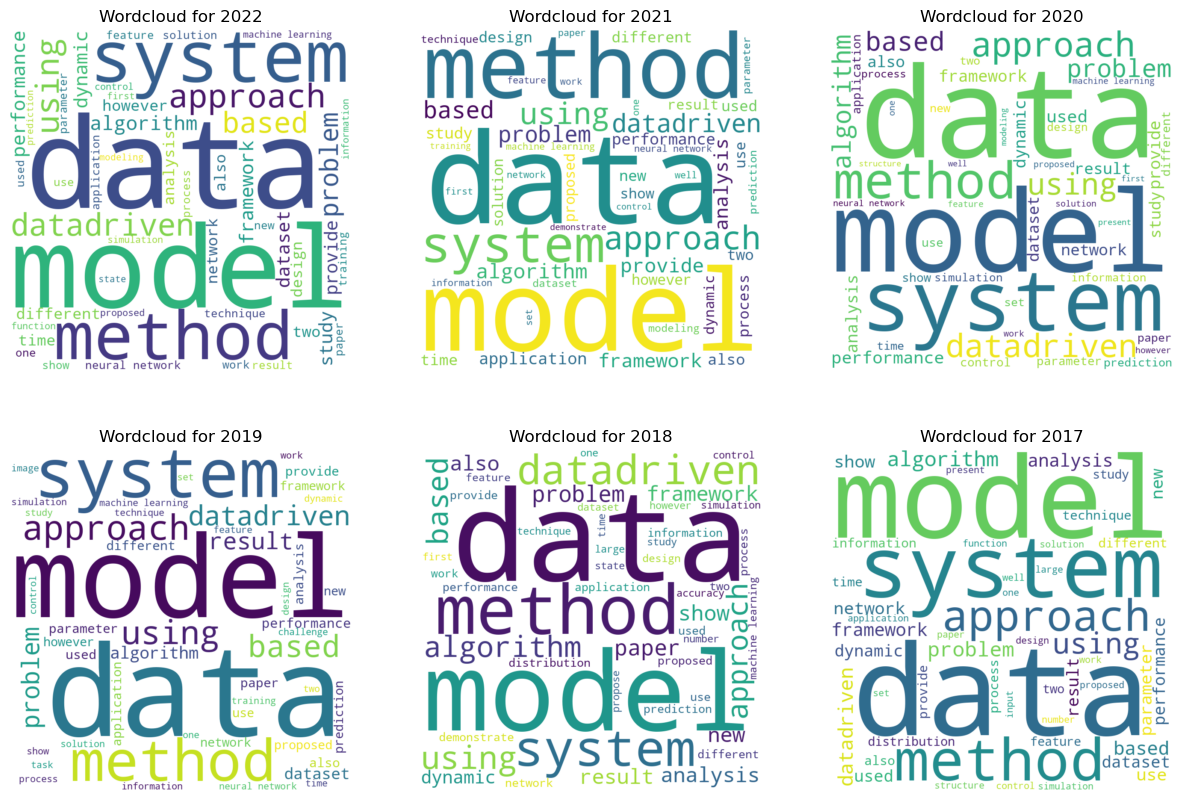

{2022: <wordcloud.wordcloud.WordCloud at 0x219c05c41c0>,
 2021: <wordcloud.wordcloud.WordCloud at 0x219b48283d0>,
 2020: <wordcloud.wordcloud.WordCloud at 0x219c04fa970>,
 2019: <wordcloud.wordcloud.WordCloud at 0x219c051fc40>,
 2018: <wordcloud.wordcloud.WordCloud at 0x219c054d610>,
 2017: <wordcloud.wordcloud.WordCloud at 0x219c0576070>}

In [42]:
def create_wordclouds(stopwords):
    dict_wordclouds = dict()
    # Subplots für die Jahre 2017-2022
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

    # Für jedes Jahr eine Wortwolke generieren und in der entsprechenden plotten
    for i, year in enumerate(data_dict.keys()):
        # Daten aus dem Jahr herausfiltern
        year_data = df_analyse[df_analyse['year'] == year]

        # Erstellen Sie eine Textdatei aus allen Texten für das aktuelle Jahr
        year_text = ' '.join(year_data['summary_lemmatized'])

        # Erstellen Sie eine Wordcloud für das aktuelle Jahr
        wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=stopwords, max_words=50, min_font_size=10).generate(year_text)
        dict_wordclouds[year] = wordcloud
        
        # Plot the Wordcloud in the corresponding subplot
        axs[i//3][i%3].imshow(wordcloud, interpolation='bilinear')
        axs[i//3][i%3].set_title(f'Wordcloud for {year}')
        axs[i//3][i%3].axis("off")

    plt.show()
    return dict_wordclouds
    
create_wordclouds(stopwords=[])

> Die Wordcloud verleiht den häufiger vorkommenden Wörtern mehr Struktur jedoch verwischt diese auch mögliche "Topics", die beim LDA noch besser erkennbar sind.

> Man könnte die hier am häufigsten über alle Jahre dargestellten Wörter (model, method, data, system, datadriven (als Teil des Titels)) als stopwörter in die Wordcloud einbauen und den anderen Wörtern mehr Gewicht geben, da diese offensichtlich über alle Jahre hinweg eine gleichbleibende Relevanz aufweisen:

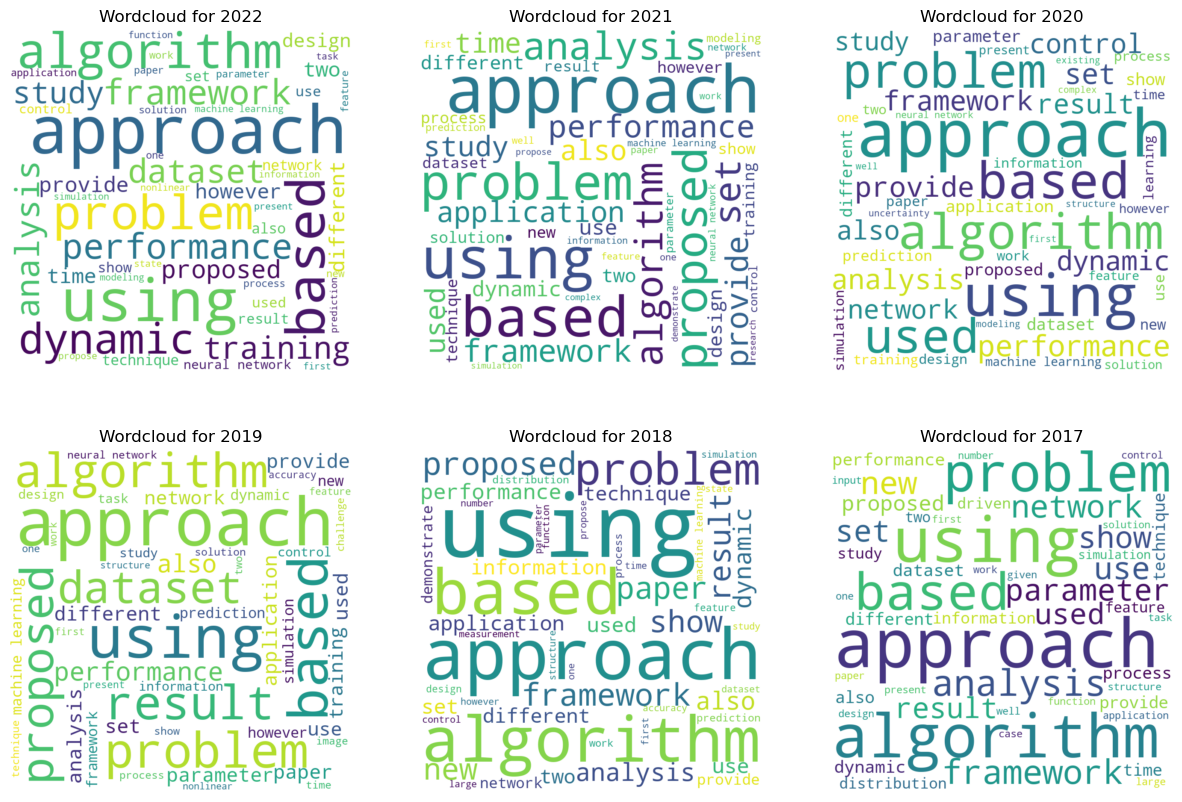

In [43]:
dict_wordclouds = create_wordclouds(stopwords=['model', 'method', 'data', 'system', 'datadriven'])

> Hier erkennt man, dass in einigen Jahren Themen Probleme einen höheren Stellenwert hatten (2017, 2019, 2020, 2021) in anderen Jahren das framework (2018, 2022) und so weiter. Man könnte programmatisch auch die Unterschiede zwischen den Jahren vergleichen:

In [44]:
top_words_2017 = dict(sorted(dict_wordclouds[2017].words_.items(), key=lambda item: item[1], reverse=True)[:10])
top_words_2022 = dict(sorted(dict_wordclouds[2022].words_.items(), key=lambda item: item[1], reverse=True)[:10])

diff = {}
for word in top_words_2017.keys():
    if word in top_words_2022.keys():
        diff[word] = top_words_2022[word] - top_words_2017[word]
    else:
        diff[word] = -1 * top_words_2017[word]
for word in top_words_2022.keys():
    if word not in top_words_2017.keys():
        diff[word] = top_words_2022[word] - top_words_2017.get(word, 0)
        
diff

{'approach': 0.0,
 'using': -0.06312013282207374,
 'algorithm': -0.2533600822231885,
 'problem': -0.2922579752539827,
 'based': -0.07322014468118743,
 'analysis': -0.2525793572360359,
 'framework': -0.11087283077044707,
 'new': -0.5121951219512195,
 'network': -0.5060975609756098,
 'use': -0.49390243902439024,
 'dynamic': 0.47974068071312803,
 'performance': 0.47811993517017826,
 'dataset': 0.4213938411669368}

> Das Dictionary diff gibt die Differenz der Werte zwischen den beiden Dictionaries aus. Wenn ein Wort in beiden Dictionaries enthalten ist, wird die Differenz zwischen dem Wert im Dictionary top_words_2022 und dem Wert im Dictionary top_words_2017 berechnet und als Wert im Dictionary diff gespeichert. 

> - Bedeutung der Werte
>   - Positive Werte = Kommt häufiger im Jahr 2022 vor
>   - negative Werte = Kommt häufiger im Jahr 2017 vor
  
> Performance, Dynamic und Training haben hierbei stärker an Bedeutung gewonnen.

> New, Network und use haben dabei stärker an Bedeutung von 2017 bis 2022 verloren.

In [45]:
fig = go.Figure()

# Sortiere die Items nach den Werten in absteigender Reihenfolge
sorted_items = sorted(diff.items(), key=lambda x: x[1], reverse=True)

fig.add_trace(
    go.Bar(
        x=[item[0] for item in sorted_items],
        y=[item[1] for item in sorted_items],
        marker_color=['green' if value > 0 else 'red' for key, value in sorted_items]
    )
)

fig.update_layout(
    title='Wortrelevanz - Unterschied zwischen 2017 und 2022',
    xaxis_title='Wort',
    yaxis_title='Bedeutung/Relevanz',
)

fig.show()

Ausblick: Man könnte auch hier im nächsten Schritt eine Entwicklung der häufigsten Wörter über die einzelnen Jahre erstellen und die Veränderungen darstellen. 

### 4.4. Auswertung (Evaluation)  <a name="Evaluation"></a>

Die Verwendung von LDA und Wordclouds zur Auswertung der Themenfelder von wissenschaftlichen Artikeln in Bezug auf datadriven hat jeweils ihre Vor- und Nachteile.

LDA ist eine robuste und akkurate Methode, um verborgene Themen in einer großen Textsammlung zu identifizieren. Es verwendet eine statistische Modellierungstechnik, um die Wahrscheinlichkeit zu bestimmen, dass ein bestimmtes Thema in einem Dokument vorhanden ist. Die Ergebnisse können als Liste von Themen oder als Hierarchie von Themen präsentiert werden, die auf der Ähnlichkeit der Wörter und Konzepte in den Dokumenten basieren. Die Genauigkeit der Ergebnisse hängt jedoch von der Qualität der Eingangsdaten und der richtigen Wahl der Parameter ab.

Im Vergleich dazu bieten Wordclouds eine schnelle und visuell ansprechende Möglichkeit, um die wichtigsten Wörter und Konzepte in einer Textsammlung zu identifizieren. Es kann als eine Art Vorschau oder Zusammenfassung des Inhalts dienen. Wordclouds sind jedoch oft oberflächlicher als LDA, da sie nur auf der Häufigkeit der Wörter basieren und keine Zusammenhänge oder Abhängigkeiten zwischen den Wörtern berücksichtigen. Die Ergebnisse können auch von der Größe und Formatierung der Wordcloud beeinflusst werden.

Wenn es darum geht, komplexe und detaillierte Informationen aus einer großen Menge von Texten zu extrahieren, ist LDA in der Regel die bessere Wahl, da es eine höhere Genauigkeit und Flexibilität bietet. Wordclouds können jedoch als schnelles und einfaches Werkzeug zur Identifizierung von Trends und Schlüsselwörtern in einer Textsammlung dienen. Die Wahl zwischen LDA und Wordclouds hängt von den spezifischen Anforderungen und Zielen des Projekts ab.

> Ausblick:
Bei der Verwendung von LDA könnte jeweils für die Jahre noch jeweils der Kohärenzscore ermittelt werden, damit lässt sich die Qualität der identifizierten Themen in der Themenmodellierung bewerten. Der Score gibt an, wie gut die Wörter in einem Thema zusammenpassen und wie interpretierbar das Thema ist. Ein niedriger Score bedeutet, dass die Wöerter im Thema eng miterinander verbunden sind. Ein niedriger Score hingegen deutet darauf hin, dass das Thema unspezifisch oder zu allgemein ist und die Wörter zufällig zusammengestellt sind.


Beispiel für die Berechnung des Kohärenzscores für das Jahr 2022.

In [46]:
# Daten für das Jahr 2022
df_analyse_data = data_dict[2022]["data"]
data_tokens = [doc.split() for doc in df_analyse_data]

# Erstellen des Wörterbuchs
dictionary = Dictionary(data_tokens)

# Trainieren des LDA-Modells
lda_model = LdaModel(corpus=[dictionary.doc2bow(tokens) for tokens in data_tokens], id2word=dictionary, num_topics=10, random_state=42)

# Berechnen des Kohärenzscores
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_tokens, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('Der Kohärenzscore für das LDA-Modell beträgt:', coherence_lda)


Der Kohärenzscore für das LDA-Modell beträgt: 0.2990042732661493


> In Ihrem Fall beträgt der Kohärenzscore für das LDA-Modell 0,299. Das bedeutet, dass die Themen innerhalb des Modells nicht sehr gut zusammenhängen und möglicherweise weiter optimiert werden müssen. Ein Kohärenzscore von 0,3 gilt jedoch immer noch als "gut" für ein LDA-Modell, insbesondere wenn es viele Themen gibt oder die Texte schwer zu gruppieren sind. Was hier im Themenbereich "datadriven" vorliegt. Die Themen in 2022 waren stark unterschiedlich und konnten somit nicht "gut" zusammengeführt werden.